In [1]:
import pandas as pd
import os
import pydicom
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define paths (same as in your original script)
study = '/home/reza/oai-knee-classification/'
data_raw = study + 'Data_Raw/'
outinfo_path = data_raw + '/output_info/'
output_base_path = "~/oai-knee-classification/Data_Reduced/dicoms"
extraction_log_csv = os.path.expanduser(outinfo_path + 'extraction_log.csv')
output_csv = os.path.expanduser(outinfo_path + 'dicom_file_list.csv')

In [3]:
# Function to check if a file is a valid DICOM
def is_dicom_file(filepath):
    try:
        pydicom.dcmread(filepath)
        return True
    except pydicom.errors.InvalidDicomError:
        return False
    except Exception as e:
        print(f"Error checking DICOM {filepath}: {str(e)}")
        return False

In [5]:
# Start timing
start_time = time.perf_counter()

# Load extraction log
extraction_df = pd.read_csv(extraction_log_csv)

# Filter for successfully extracted knee DICOMs
knee_df = extraction_df[extraction_df['is_knee'] == True]
print( knee_df['src_subject_id'].nunique())

# Initialize list to store DICOM file details
dicom_files = []

3459


In [6]:
# Process each extracted knee DICOM entry
for _, row in knee_df.iterrows():
    subject_id = row['src_subject_id']
    date_folder = row['date_folder']
    tar_file = row['tar_file']
    extracted_path = os.path.expanduser(row['extracted_path'])

    # Check if the extracted path exists
    if not os.path.exists(extracted_path):
        print(f"Warning: Extracted path {extracted_path} does not exist")
        continue

    # Walk through the extracted directory to find DICOM files
    for root, _, files in os.walk(extracted_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            if is_dicom_file(file_path):
                try:
                    # Read DICOM metadata
                    ds = pydicom.dcmread(file_path)
                    dicom_files.append({
                        'src_subject_id': subject_id,
                        'date_folder': date_folder,
                        'tar_file': tar_file,
                        'dicom_path': file_path,
                        'study_id': ds.get((0x0008, 0x0060), None).value if ds.get((0x0008, 0x0060), None) else None,
                        'series_description': ds.get((0x0008, 0x103E), None).value if ds.get((0x0008, 0x103E), None) else None,
                        'body_part_examined': ds.get((0x0018, 0x0015), None).value if ds.get((0x0018, 0x0015), None) else None
                    })
                except Exception as e:
                    print(f"Error reading DICOM {file_path}: {str(e)}")
                    dicom_files.append({
                        'src_subject_id': subject_id,
                        'date_folder': date_folder,
                        'tar_file': tar_file,
                        'dicom_path': file_path,
                        'study_id': None,
                        'series_description': None,
                        'body_part_examined': None,
                        'error': str(e)
                    })

# Create DataFrame and save to CSV
output_df = pd.DataFrame(dicom_files)
output_df.to_csv(output_csv, index=False)

# Calculate and print runtime
end_time = time.perf_counter()
runtime_seconds = end_time - start_time
runtime_minutes = runtime_seconds / 60
print(f"Listed {len(output_df)} DICOM files and saved to {output_csv}")
print(f"Runtime: {runtime_seconds:.2f} seconds ({runtime_minutes:.2f} minutes)")

/home/reza/oai-knee-classification/myenv/lib/python3.12/site-packages/pydicom/charset.py:727: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Listed 3670 DICOM files and saved to /home/reza/oai-knee-classification/Data_Raw//output_info/dicom_file_list.csv
Runtime: 530.46 seconds (8.84 minutes)


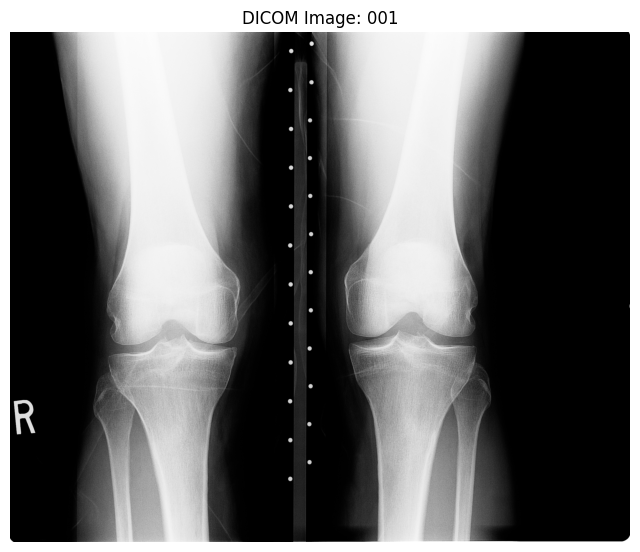

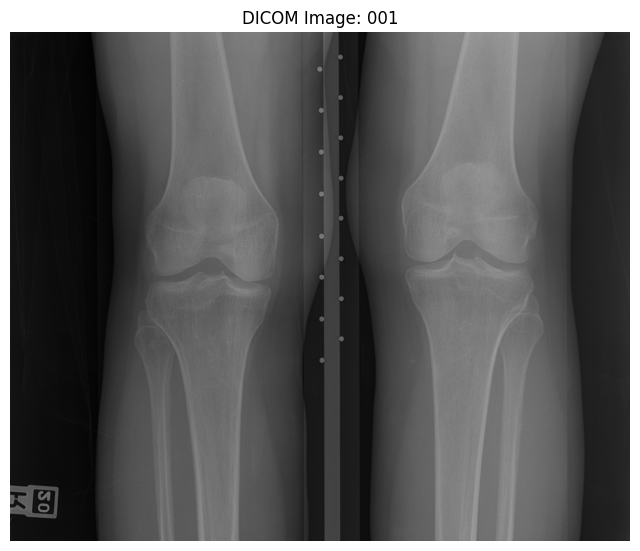

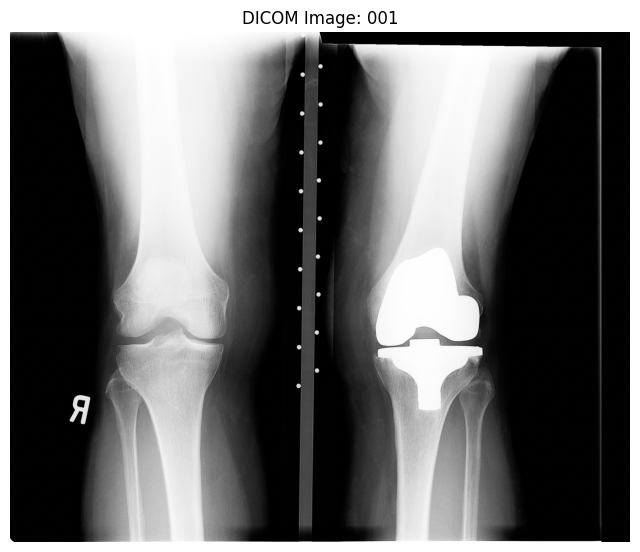

In [32]:
sample_dicom_path = output_df['dicom_path'][2457:2460]

# Path to a single DICOM file (replace with your file path)
# dicom_path = "~/oai-knee-classification/Data_Reduced/dicoms/12345/20200101/image1/file1.dcm"

for dicomfile in sample_dicom_path:
        
    # Read the DICOM file
    try:
        ds = pydicom.dcmread(dicomfile)
        # Extract pixel data
        pixel_array = ds.pixel_array
        
        # Plot the image
        plt.figure(figsize=(8, 8))
        plt.imshow(pixel_array, cmap='gray')  # Use grayscale for X-ray images
        plt.title(f"DICOM Image: {os.path.basename(dicomfile)}")
        plt.axis('off')  # Hide axes for cleaner visualization
        plt.show()
        
    except Exception as e:
        print(f"Error reading or plotting DICOM {dicomfile}: {str(e)}")